In [1]:
import pandas as pd

In [2]:
train_data = pd.read_csv('./sign_mnist_train/sign_mnist_train.csv')
test_data = pd.read_csv('./sign_mnist_test/sign_mnist_test.csv')

x_train = train_data.iloc[:, 1:].values
x_test = test_data.iloc[:, 1:].values

y_train = train_data.iloc[:, 0].values #Integer labels from 0 - 25
y_test = test_data.iloc[:, 0].values

x_train = x_train / 255.0 #Normalizing the dataset
x_test = x_test / 255.0

x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)


In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout




In [4]:
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(26, activation='softmax')  # 26 output classes for the 26 hand signs
])

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(x_train, y_train, batch_size=32), epochs=15, validation_data=(x_test, y_test))


Epoch 1/15

858/858 [==============================] - 18s 20ms/step - loss: 0.3158 - accuracy: 0.8956 - val_loss: 0.0659 - val_accuracy: 0.9806
Epoch 2/15
858/858 [==============================] - 13s 16ms/step - loss: 0.3129 - accuracy: 0.8933 - val_loss: 0.0564 - val_accuracy: 0.9929
Epoch 3/15
858/858 [==============================] - 14s 17ms/step - loss: 0.2996 - accuracy: 0.8989 - val_loss: 0.0611 - val_accuracy: 0.9861
Epoch 4/15
858/858 [==============================] - 14s 16ms/step - loss: 0.2918 - accuracy: 0.8991 - val_loss: 0.0482 - val_accuracy: 0.9925
Epoch 5/15
858/858 [==============================] - 14s 17ms/step - loss: 0.2745 - accuracy: 0.9055 - val_loss: 0.0527 - val_accuracy: 0.9865
Epoch 6/15
858/858 [==============================] - 21s 24ms/step - loss: 0.2691 - accuracy: 0.9091 - val_loss: 0.0646 - val_accuracy: 0.9844
Epoch 7/15
858/858 [==============================] - 27s 31ms/step - loss: 0.2667 - accuracy: 0.9096 - val_loss: 0.0456 - val_accurac

In [10]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')


225/225 [==============================] - 1s 3ms/step - loss: 0.0341 - accuracy: 0.9891
Test accuracy: 0.9891243577003479


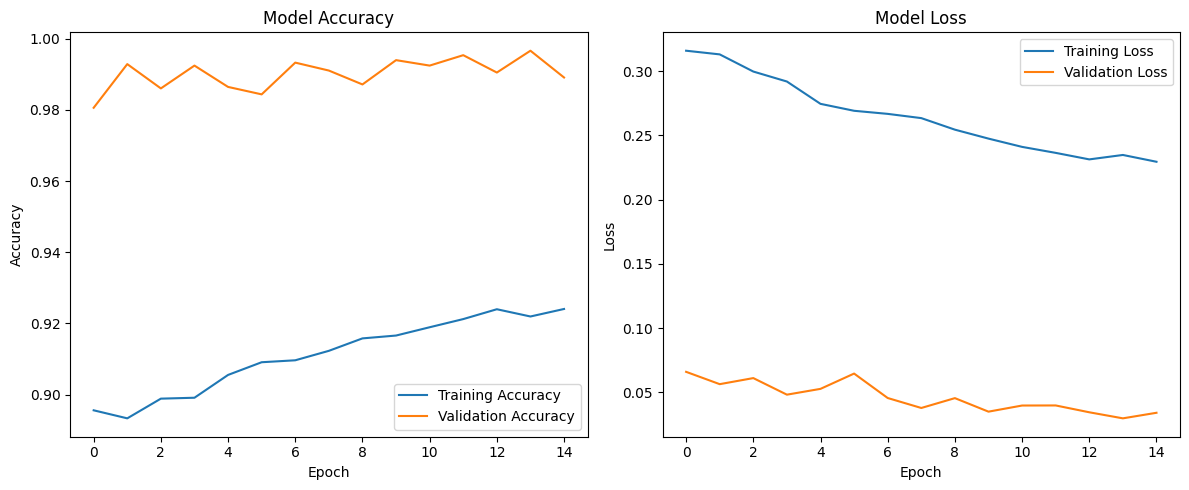

In [11]:
import matplotlib.pyplot as plt

# Assuming you have stored the history from model training
# Example: history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15)

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Show plots
plt.tight_layout()
plt.show()


In [8]:
#Run this to save the model
model.save('hand_sign_mnist_model.h5')


c:\Users\karte\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [6]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('hand_sign_mnist_model.h5')


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Evaluate the model on the test set to get loss and accuracy
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_acc}')

# Generate predictions on the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert predictions to class labels

# If y_test is already in label format, no need for np.argmax
y_true = y_test  # Use y_test directly if it's not one-hot encoded

# Calculate additional metrics
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


225/225 [==============================] - 1s 4ms/step - loss: 0.0341 - accuracy: 0.9891
Test loss: 0.034090232104063034
Test accuracy: 0.9891243577003479
225/225 [==============================] - 1s 3ms/step
Precision: 0.9900117577377904
Recall: 0.9891243725599553
F1 Score: 0.989080772709489


In [7]:
import cv2
import mediapipe as mp
import numpy as np

# Initialize MediaPipe hand detector
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(max_num_hands=2)
mp_draw = mp.solutions.drawing_utils

# Start webcam feed
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    # Convert the image to RGB as Mediapipe uses RGB images
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Detect hands in the frame
    results = hands.process(rgb_frame)
    
    # Draw landmarks and connections if hands are detected
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:

            # Get image dimensions
            h, w, c = frame.shape

            # Get coordinates of hand landmarks
            landmark_points = []
            for lm in hand_landmarks.landmark:
                cx, cy = int(lm.x * w), int(lm.y * h)
                landmark_points.append((cx, cy))

             # Calculate the bounding box around the hand
            x_min = min([point[0] for point in landmark_points])
            x_max = max([point[0] for point in landmark_points])
            y_min = min([point[1] for point in landmark_points])
            y_max = max([point[1] for point in landmark_points])

            # Add some padding to the bounding box
            padding = 20
            x_min = max(0, x_min - padding)
            x_max = min(w, x_max + padding)
            y_min = max(0, y_min - padding)
            y_max = min(h, y_max + padding)

            # Calculate the width and height of the bounding box
            box_width = x_max - x_min
            box_height = y_max - y_min

            # Find the larger of the width or height to make the bounding box a square
            box_size = max(box_width, box_height)

            # Adjust the x and y coordinates to make the bounding box square
            x_center = (x_min + x_max) // 2
            y_center = (y_min + y_max) // 2

            x_min = max(0, x_center - box_size // 2)
            x_max = min(w, x_center + box_size // 2)
            y_min = max(0, y_center - box_size // 2)
            y_max = min(h, y_center + box_size // 2)

            # Extract the region of interest (hand) as a square
            hand_roi = frame[y_min:y_max, x_min:x_max]


            # Optionally resize the ROI to match CNN input size
            
            hand_roi_resized = cv2.resize(hand_roi, (28, 28))
            hand_roi_resized = cv2.cvtColor(hand_roi_resized, cv2.COLOR_BGR2GRAY)
            #hand_roi_resized = cv2.GaussianBlur(hand_roi_resized, (5, 5), 0)
            hand_cnn_input = hand_roi_resized / 255.0
            hand_cnn_input = np.expand_dims(hand_cnn_input, axis=-1)
            hand_cnn_input = np.expand_dims(hand_cnn_input, axis=0)
            predictions = model.predict(hand_cnn_input)
            predicted_class = np.argmax(predictions, axis=1)[0]
            cv2.putText(frame, chr(predicted_class + 65), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0), 2, cv2.LINE_AA)
            #print(predictions)
            

            # Draw the bounding box around the hand
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
    # Display the result
    cv2.imshow("Hand Detection", frame)
    
    # Break loop on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()


c:\Users\karte\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 [==============================] - 0s 33ms/step
